In [2]:
import pandas as pd



google_stock_data = pd.read_csv("google-data.csv")


google_stock_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [4]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = google_stock_data[['Date', 'Close']]
prophet_data = prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}) # DO NOT USE INPLACE EVER

# Create and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_data)

# Display the first few rows of the prepared data
prophet_data.head()

13:57:48 - cmdstanpy - INFO - Chain [1] start processing
13:57:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


In [13]:
# Python
future = model.make_future_dataframe(periods=365*3)
future.head()

,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-07
4,2013-01-08


In [14]:
# Python
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()



,ds,yhat,yhat_lower,yhat_upper
0,2013-01-02,373.416921,343.249425,404.428092
1,2013-01-03,372.127568,343.362617,401.328953
2,2013-01-04,372.051886,342.338292,400.009979
3,2013-01-07,370.390916,340.305723,402.244247
4,2013-01-08,370.493479,339.272910,400.846872


C:\Users\Emil\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Emil\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


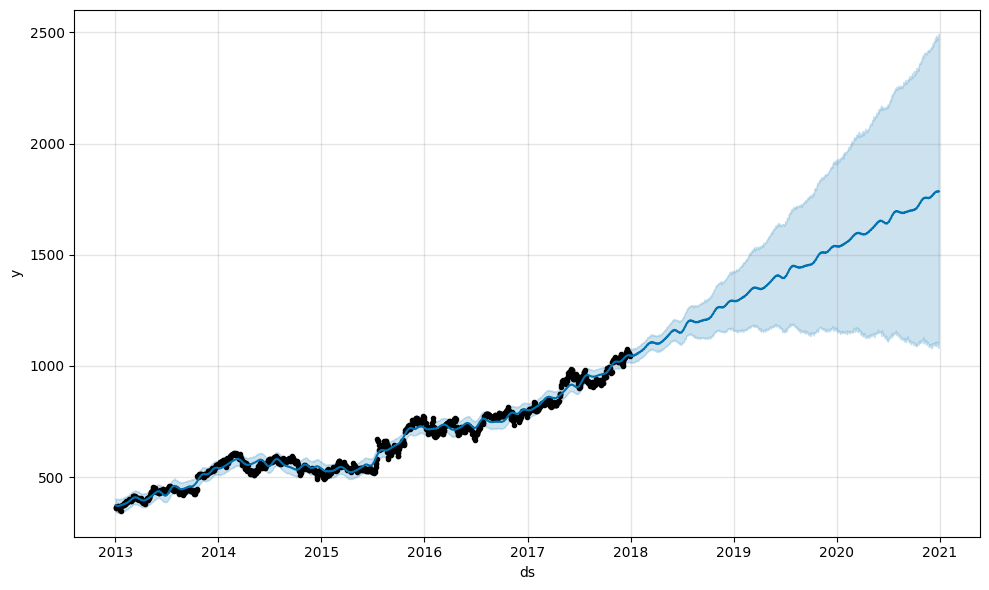

In [15]:
# Python
fig1 = model.plot(forecast)



In [ ]:
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd


# Objective function to be optimized
def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        
    }

    # Create a Prophet model with the suggested parameters
    model = Prophet(**param)
    model.fit(prophet_data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Extract and return the mean absolute error (MAE)
    mae = df_p['mae'].mean()
    return mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Best parameters
print('Best parameters:', study.best_params)


[I 2023-12-27 14:13:34,966] A new study created in memory with name: no-name-74244c1b-5d1b-44e0-aa4f-0b2072728a02
14:13:35 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.00s/it]14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing

 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:09,  3.16s/it]14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████▍                 